## Project Introduction 

This project implements a Generative Adversarial Network (GAN) to generate images in the style of Monet's paintings. The dataset contains four directories:

- **monet_tfrec** and **monet_jpg**: Monet's original paintings (same images, different formats)
- **photo_tfrec** and **photo_jpg**: Real photographs (same images, different formats)

The goal is to train a GAN that can generate 7,000 to 10,000 Monet-style images. A GAN consists of two neural networks:

1. **Generator**: Creates images in Monet's style
2. **Discriminator**: Distinguishes between real Monet paintings and generated images

The two models work adversarially: the generator tries to fool the discriminator, while the discriminator tries to accurately classify real vs. generated images.




## Data Loading and EDA

Monet JPG files: 300
Photo JPG files: 7038
Monet TFRecord files: 5
Photo TFRecord files: 20


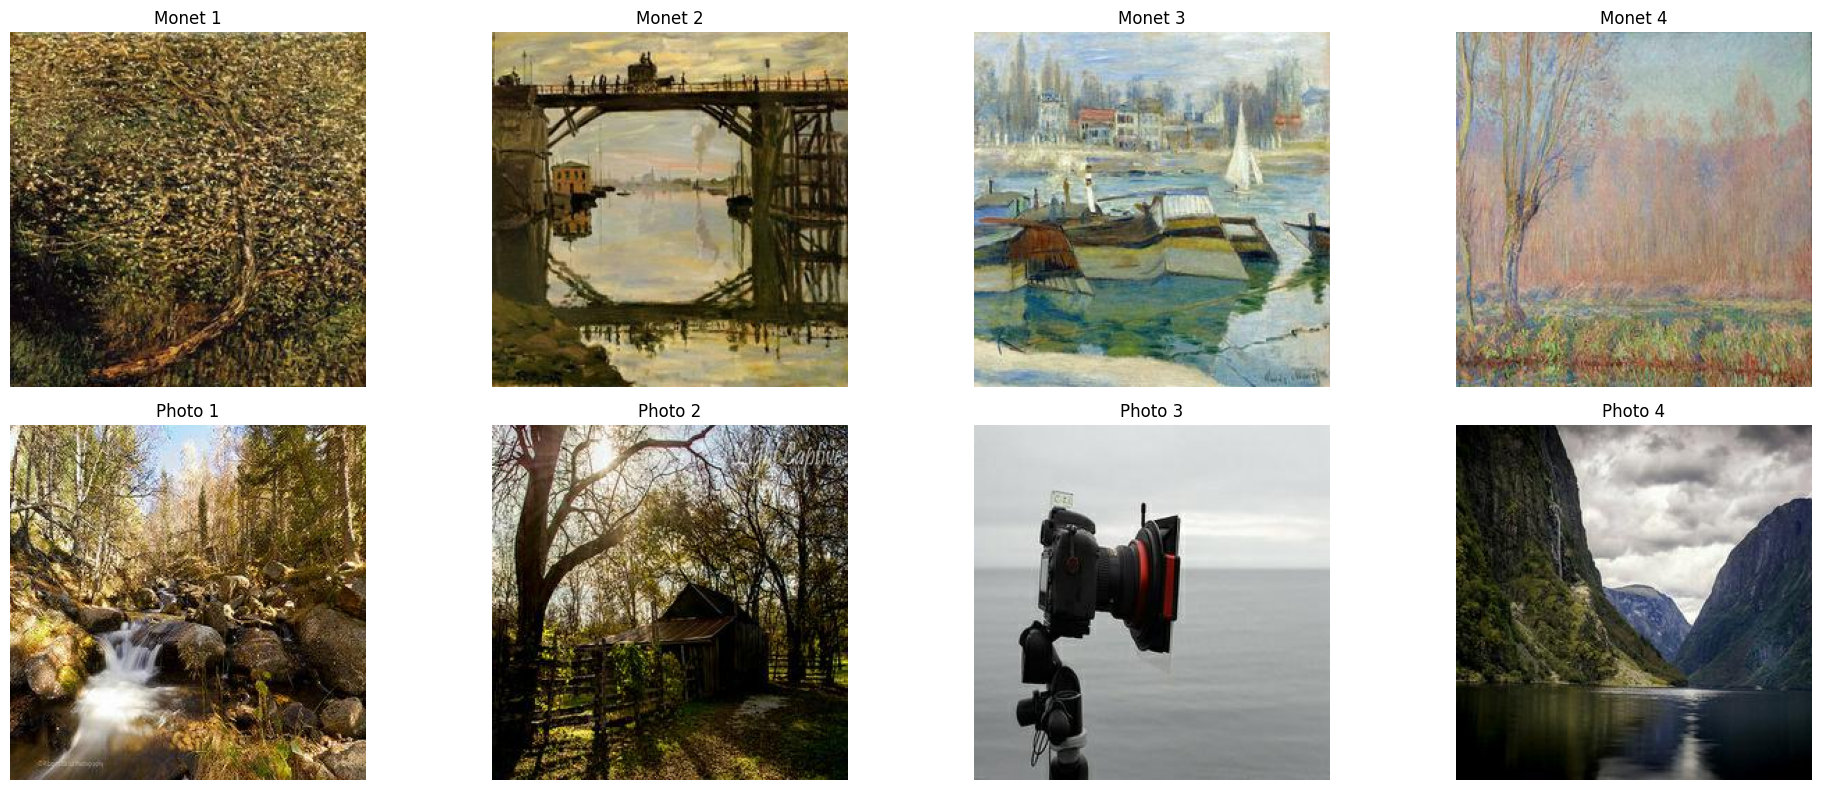

In [5]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Paths
MONET_JPG_PATH = "../data/monet_jpg/"
PHOTO_JPG_PATH = "../data/photo_jpg/"
MONET_TFREC_PATH = "../data/monet_tfrec/"
PHOTO_TFREC_PATH = "../data/photo_tfrec/"

# File counts
monet_jpg_files = glob.glob(os.path.join(MONET_JPG_PATH, "*.jpg"))
photo_jpg_files = glob.glob(os.path.join(PHOTO_JPG_PATH, "*.jpg"))
monet_tfrec_files = glob.glob(os.path.join(MONET_TFREC_PATH, "*.tfrec"))
photo_tfrec_files = glob.glob(os.path.join(PHOTO_TFREC_PATH, "*.tfrec"))

print(f"Monet JPG files: {len(monet_jpg_files)}")
print(f"Photo JPG files: {len(photo_jpg_files)}")
print(f"Monet TFRecord files: {len(monet_tfrec_files)}")
print(f"Photo TFRecord files: {len(photo_tfrec_files)}")

# Display sample images
def display_sample_images(monet_files, photo_files, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    monet_samples = np.random.choice(monet_files, num_samples, replace=False)
    photo_samples = np.random.choice(photo_files, num_samples, replace=False)
    for i, img_path in enumerate(monet_samples):
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Monet {i+1}")
        axes[0, i].axis('off')
    for i, img_path in enumerate(photo_samples):
        img = Image.open(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Photo {i+1}")
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(monet_jpg_files, photo_jpg_files)

## Model Generation

### Generator Architecture

The generator is a simple **DCGAN (Deep Convolutional GAN)** architecture with progressive upsampling. Each layer is explained below:

#### 1. **Input Layer (Dense)**
```python
layers.Dense(8*8*256, use_bias=False, input_shape=(LATENT_DIM,))
```
- **Purpose**: Transforms random noise (100-dimensional) into a spatial representation
- **Rationale**: 
  - 8×8 provides a good starting spatial resolution for upsampling
  - 256 channels allow rich feature representation
  - `use_bias=False` because BatchNormalization will handle the bias

#### 2. **BatchNormalization + LeakyReLU + Reshape Layer**
```python
layers.BatchNormalization()
layers.LeakyReLU()
```
- **BatchNormalization**: Stabilizes training by normalizing activations
- **LeakyReLU**: Prevents dying ReLU problem (allows small negative gradients)
- **Reshape**: Converts flat tensor to spatial 8×8×512 feature map

#### 3. **Four Progressive Upsampling Blocks**
Each block follows the pattern: `Conv2DTranspose → BatchNorm → LeakyReLU`

**Block Progression:**
- 8×8 → 16×16 (256 channels)
- 16×16 → 32×32 (128 channels)
- 32×32 → 64×64 (64 channels)
- 64×64 → 128×128 (32 channels)

**Rationale for Upsampling Strategy:**
- **Kernel size=4**: Provides sufficient receptive field for feature synthesis.
- **Decreasing channels**: As spatial resolution increases, fewer channels are needed.
- **Progressive detail**: Each layer adds finer spatial details.

#### 4. **Final Output Layer**
```python
layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', activation='tanh')
```
- **3 channels**: RGB color space
- **Stride=1**: Maintains 256×256 spatial resolution
- **tanh activation**: Outputs values in [-1, 1] range (matches normalized input data)

### Discriminator Architecture

The discriminator uses a **mirror image** of the generator with downsampling:

#### 1. **Input Layer**
```python
layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[128, 128, 3])
```
- **Purpose**: First downsampling layer (128×128 → 64×64)
- **64 channels**: Start with moderate feature extraction
- **Stride=2**: Reduces spatial dimensions by half

#### 2. **Four Progressive Downsampling (Opposite of Generator)**
Each block: `Conv2D → LeakyReLU → Dropout`

**Block Progression:**
- 128×128 → 64×64 
- 64×64 → 32×32 
- 32×32 → 16×16 
- 16x16 → 4×4 

**Rationale:**
- **Increasing channels**: As spatial resolution decreases, more channels capture complex features
- **Dropout (0.3)**: Prevents overfitting and improves generalization
- **LeakyReLU**: Consistent with generator for stable training

#### 3. **Classification Head**
```python
layers.Flatten()
layers.Dense(1)
```
- **Flatten**: Converts spatial features to 1D vector
- **Dense(1)**: Binary classification (real vs. fake)
- **No activation**: Uses logits for binary crossentropy loss

### Why This Architecture Works for Monet Style Transfer

1. **Spatial Resolution**: 128x128 captures Monet's impressionistic brushstrokes
2. **Feature Depth**: 256 channels in early layers capture complex color relationships
3. **Progressive Detail**: Matches Monet's technique of building layers of paint
4. **Stable Training**: Architecture prevents mode collapse and training instability
5. **Memory Efficient**: Balanced parameter count for both networks

I chose DCGAN architecture as baseline model which effectively demonstrate the basic functioning of GAN. It provides the best starting point because of simplicity, effectiveness, and training stability for the given dataset and computational constraints for my Old 2015 Macbook Pro.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = 128  # Reduced from 256
BATCH_SIZE = 8   # Reduced from 16
LATENT_DIM = 64  # Reduced from 100
BUFFER_SIZE = 500 # 

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return img

def create_dataset(image_paths, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Simplified Generator
def make_generator_model():
    model = tf.keras.Sequential()
    # Start with 4x4 
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 256)))
    
    # 4 upsampling layers
    # 4x4 -> 8x8
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 64x64 -> 128x128
    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Simplified Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    # 128x128 -> 64x64
    model.add(layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 64x64 -> 32x32
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 32x32 -> 16x16
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 16x16 -> 8x8
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # 8x8 -> 4x4
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model


generator = make_generator_model()
discriminator = make_discriminator_model()

In [7]:
print('Generator Summary')
generator.summary()



print('Discriminator Summary')
discriminator.summary()

Generator Summary


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4096)           │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 8, 8, 128)      │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 16, 16, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 16)     │         8,192 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 128, 128, 3)    │           768 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 976,576 (3.73 MB)

 Trainable params: 967,904 (3.69 MB)

 Non-trainable params: 8,672 (33.88 KB)

Discriminator Summary


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,743,073 (6.65 MB)

 Trainable params: 1,743,073 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In this section we will go ahead and train our model. Some trainig stretegies:
- `Epoch = 200` I tried will 50, 100 nothing was giving good results
- Model checkpoints are very important in this case as it is quiet compute intensive processes.
- Train function generates sample images after every 5 epochs to see if model training is getting better.
- Also created a `generate_and_save_images` function to be called after model is trained.

Restoring from checkpoint: ./training_checkpoints/ckpt-76
Showing sample output for 10 Epochs only....
Starting training with 38 batches per epoch

Epoch 1/10
  Batch 1, Gen Loss: 3.5948, Disc Loss: 0.2958
  Batch 11, Gen Loss: 2.6013, Disc Loss: 0.3007
  Batch 21, Gen Loss: 3.3182, Disc Loss: 0.2998
  Batch 31, Gen Loss: 3.7706, Disc Loss: 0.3201


2025-06-22 23:41:47.219758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 completed in 19.6s. Avg Gen Loss: 2.9812, Avg Disc Loss: 0.4444

Epoch 2/10
  Batch 1, Gen Loss: 1.7859, Disc Loss: 0.5579
  Batch 11, Gen Loss: 3.0692, Disc Loss: 0.3720
  Batch 21, Gen Loss: 1.5888, Disc Loss: 0.9216
  Batch 31, Gen Loss: 3.1150, Disc Loss: 0.3020


2025-06-22 23:41:57.543463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 completed in 10.3s. Avg Gen Loss: 2.8377, Avg Disc Loss: 0.4430

Epoch 3/10
  Batch 1, Gen Loss: 2.4000, Disc Loss: 0.2734
  Batch 11, Gen Loss: 3.6142, Disc Loss: 0.4745
  Batch 21, Gen Loss: 2.9942, Disc Loss: 0.1741
  Batch 31, Gen Loss: 3.8018, Disc Loss: 0.2944


2025-06-22 23:42:09.420800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 completed in 11.9s. Avg Gen Loss: 3.1087, Avg Disc Loss: 0.4125

Epoch 4/10
  Batch 1, Gen Loss: 1.7317, Disc Loss: 0.9282
  Batch 11, Gen Loss: 2.4179, Disc Loss: 0.2347
  Batch 21, Gen Loss: 2.0315, Disc Loss: 0.4272
  Batch 31, Gen Loss: 3.1402, Disc Loss: 0.6591


2025-06-22 23:42:20.139111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 completed in 10.7s. Avg Gen Loss: 2.9748, Avg Disc Loss: 0.4231

Epoch 5/10
  Batch 1, Gen Loss: 2.6747, Disc Loss: 0.5000
  Batch 11, Gen Loss: 4.3870, Disc Loss: 0.1701
  Batch 21, Gen Loss: 3.1854, Disc Loss: 0.6462
  Batch 31, Gen Loss: 3.0260, Disc Loss: 0.3656


2025-06-22 23:42:32.230577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 completed in 12.1s. Avg Gen Loss: 2.9073, Avg Disc Loss: 0.4859
Checkpoint saved for epoch 5


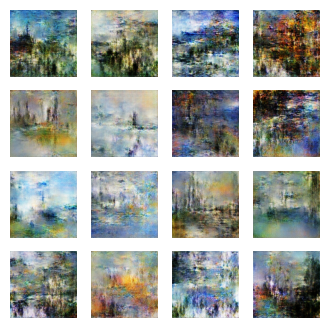


Epoch 6/10
  Batch 1, Gen Loss: 2.9097, Disc Loss: 0.2275
  Batch 11, Gen Loss: 3.1817, Disc Loss: 0.5575
  Batch 21, Gen Loss: 2.5631, Disc Loss: 0.8286
  Batch 31, Gen Loss: 1.0385, Disc Loss: 0.8706


2025-06-22 23:42:44.543825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6 completed in 11.4s. Avg Gen Loss: 2.9449, Avg Disc Loss: 0.4185

Epoch 7/10
  Batch 1, Gen Loss: 2.8480, Disc Loss: 0.1260
  Batch 11, Gen Loss: 3.0227, Disc Loss: 0.1172
  Batch 21, Gen Loss: 3.6422, Disc Loss: 0.3570
  Batch 31, Gen Loss: 2.3176, Disc Loss: 1.1099


2025-06-22 23:42:55.501393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 completed in 11.0s. Avg Gen Loss: 3.0625, Avg Disc Loss: 0.3853

Epoch 8/10
  Batch 1, Gen Loss: 3.7956, Disc Loss: 0.1171
  Batch 11, Gen Loss: 2.3955, Disc Loss: 0.2426
  Batch 21, Gen Loss: 3.3174, Disc Loss: 0.4377
  Batch 31, Gen Loss: 3.3110, Disc Loss: 0.5913


2025-06-22 23:43:06.552022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 completed in 11.1s. Avg Gen Loss: 2.8707, Avg Disc Loss: 0.3926

Epoch 9/10
  Batch 1, Gen Loss: 3.9965, Disc Loss: 0.1342
  Batch 11, Gen Loss: 3.0336, Disc Loss: 0.5832
  Batch 21, Gen Loss: 3.9440, Disc Loss: 0.3247
  Batch 31, Gen Loss: 1.9243, Disc Loss: 0.5609


2025-06-22 23:43:18.013225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9 completed in 11.5s. Avg Gen Loss: 2.9526, Avg Disc Loss: 0.3472

Epoch 10/10
  Batch 1, Gen Loss: 1.6299, Disc Loss: 0.4406
  Batch 11, Gen Loss: 3.0196, Disc Loss: 0.3189
  Batch 21, Gen Loss: 2.9040, Disc Loss: 0.1787
  Batch 31, Gen Loss: 3.2306, Disc Loss: 0.3168


2025-06-22 23:43:30.540875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10 completed in 12.5s. Avg Gen Loss: 2.8788, Avg Disc Loss: 0.3710
Checkpoint saved for epoch 10


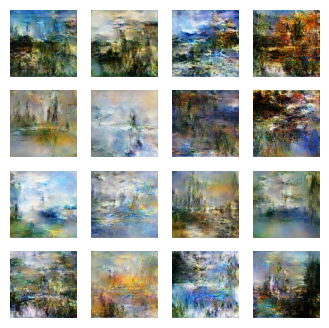

Final checkpoint saved.


In [9]:
import time

monet_dataset = create_dataset(monet_jpg_files)
photo_dataset = create_dataset(photo_jpg_files)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

EPOCHS = 10
noise_dim = LATENT_DIM
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# Model checpoint - improtant as it takes a lot of time to train this model
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a Checkpoint that will manage all the objects we want to save
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# --- Restore from the latest checkpoint ---
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print(f"Restoring from checkpoint: {latest_checkpoint}")
    checkpoint.restore(latest_checkpoint)
else:
    print("No checkpoint found. Starting training from scratch.")

@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    start_time = time.time()
    
    print(f"Starting training with {len(dataset)} batches per epoch")
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        num_batches = 0
        
        for i, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            num_batches += 1
            if i % 10 == 0: # Print progress every 10 batches
                print(f"  Batch {i+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

        avg_gen_loss = epoch_gen_loss / num_batches
        avg_disc_loss = epoch_disc_loss / num_batches
        gen_losses.append(avg_gen_loss.numpy())
        disc_losses.append(avg_disc_loss.numpy())
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_time:.1f}s. Avg Gen Loss: {avg_gen_loss:.4f}, Avg Disc Loss: {avg_disc_loss:.4f}")
        
        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved for epoch {epoch+1}")

        # Generate sample images every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, epoch + 1, seed)
    
    # Save a final checkpoint at the end of training
    checkpoint.save(file_prefix=checkpoint_prefix)
    print("Final checkpoint saved.")
    
    return gen_losses, disc_losses

# Start training

print('Showing sample output for 10 Epochs only....')
gen_losses, disc_losses = train(monet_dataset, EPOCHS)

##

## Results

After intense training session. We can see in below plot the Gen Loss in increasing and Dis loss is decreasing as epoch count increases. 

### What does it mean?

- Discriminator Loss: Model feeds the discriminator both real Monet images (label = 1) and fake/generated images (label = 0). Its loss is typically the sum of two binary-crossentropy, which tells us how well the discriminator can tell real from fake. Low Descriminator Loss means discriminator is becoming more accurate in identifying the fakes (real images scored near 1, fakes scored near 0).

- Generator Loss: The generator’s objective is to make the discriminator think its outputs are real i.e. the binary-crossentropy between the discriminator’s output on generated images and the “real” label (1). Higher G loss means discriminator is easily spotting the fakes and model is becoming better.

From the plot we can see we are on the right track and model is indeed becoming better with increasing epoch.

### What worked and What didn't?

- Longer training is definitely important as far as I can tell because When I tried with 100 epochs the model was still generaing hard to recognizing images at 200 it is getting better.

- Having checkpoints are very helpfull.

- Its hard to know at this point what is the best epoch length. 

Note: I tried training twice (First with 100 Epoch and then 200 again) and because of my checkpoint the model picked trainig from where it left so the plot below is technically from Epoch 100 - 300 

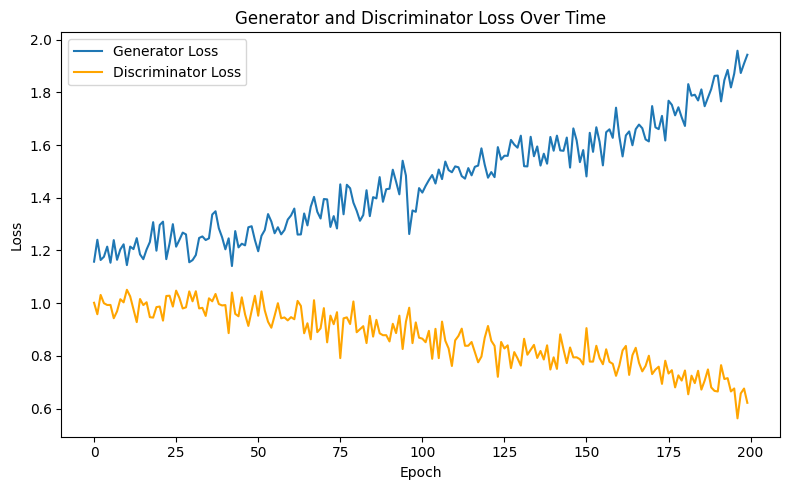

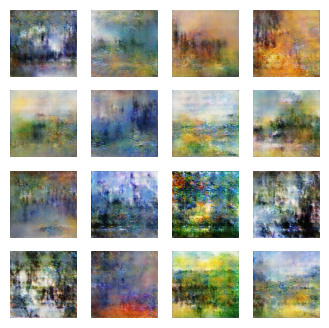

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss', color='orange')
plt.title('Generator and Discriminator Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Generate final sample images
generate_and_save_images(generator, EPOCHS, seed)

## Conclusion

The basic GAN model is demonstrated above it worked i.e, it made images from gray to some monet strokes. Having checkpoints is actually very good but I have realized that although model is picking up from older checkpoints it is not preserving the loss values from previous test run. 

## Future Work

- Try to perform hyper parameter tuning.
- Try differet more sophisticated GAN models like 

## Output

In [11]:
import os
import zipfile
from IPython.display import display, FileLink

def generate_monet_images_zip(num_images=8000, output_dir='generated_monet_images', zip_filename='images.zip'):
    os.makedirs(output_dir, exist_ok=True)
    batch_size = 100
    num_batches = (num_images + batch_size - 1) // batch_size
    image_filenames = []
    for batch in range(num_batches):
        noise = tf.random.normal([batch_size, LATENT_DIM])
        generated_images = generator(noise, training=False)
        images_np = generated_images.numpy()
        for i in range(batch_size):
            idx = batch * batch_size + i
            if idx >= num_images:
                break
            img = ((images_np[i] + 1) * 127.5).astype(np.uint8)
            img_pil = Image.fromarray(img)
            filename = f"monet_generated_{idx:06d}.jpg"
            filepath = os.path.join(output_dir, filename)
            img_pil.save(filepath)
            image_filenames.append(filepath)
    # Create a zip file containing all images
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for filepath in image_filenames:
            zipf.write(filepath, arcname=os.path.basename(filepath))
    print(f"Successfully generated {num_images} Monet-style images and zipped them as '{zip_filename}'")
    # Display a download link in the notebook
    display(FileLink(zip_filename))

generate_monet_images_zip(num_images=8)

Successfully generated 8 Monet-style images and zipped them as 'images.zip'


/Users/ajaygupta/Documents/MSCS_Codebase/Machine Learning/Deep Learning/monet_gan/notebooks/images.zip